# CRISPR gRNA Efficiency Predictor

The CRISPR gRNA Efficiency Predictor is a machine learning model designed to estimate the effectiveness of a given 20-nucleotide guide RNA (gRNA) sequence in directing CRISPR-Cas9 gene editing. It leverages a Random Forest classifier trained on experimentally measured gRNA activity data.

Each input gRNA sequence is transformed into a numerical format using one-hot encoding, capturing the presence of each nucleotide (A, T, C, G) at every position. The model analyzes these features to predict the likelihood that the gRNA will successfully target and edit the intended DNA sequence.

This predictor enables rapid in silico screening of candidate gRNAs, helping researchers prioritize sequences with higher predicted editing efficiency before experimental validation, thereby saving time and resources.

## Installing required packages & Clone the dataset repository

In [2]:
!pip install biopython scikit-learn matplotlib pandas seaborn
!git clone https://github.com/dagrate/public_data_crisprCas9.git
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

fatal: destination path 'public_data_crisprCas9' already exists and is not an empty directory.


## Loading the dataset & spliting

In [32]:
# Load features (gRNA one-hot encoded data)
# Assuming features are in NIHMS563765-supplement-Supp_Table_2.xlsx
X = pd.read_excel("public_data_crisprCas9/data/wang2014genetic/NIHMS563765-supplement-Supp_Table_2.xlsx", header=None)

# Load labels (activity score: 0 = bad, 1 = good gRNA)
# Assuming labels are in NIHMS563765-supplement-Supp_Table_4.xlsx
y = pd.read_excel("public_data_crisprCas9/data/wang2014genetic/NIHMS563765-supplement-Supp_Table_4.xlsx", header=None)


print("Shape of features:", X.shape)
print("Shape of labels:", y.shape)

Shape of features: (7115, 5)
Shape of labels: (7115, 8)


In [33]:
# Exclude the first column (gene names) and the first row (header) from the features
X = X.iloc[1:, 1:]

# Select the column containing the activity score (assuming it's the second column, index 1)
# and remove the header row
y = y.iloc[1:, 1]

# Convert y to numeric, coercing errors, and drop NaN values
y = pd.to_numeric(y, errors='coerce').dropna()

# Convert continuous activity scores to binary labels (0 for bad, 1 for good)
# using the median as the threshold
median_activity = y.median()
y = (y > median_activity).astype(int)

# Ensure X and y have the same index after dropping rows from y
X = X.loc[y.index]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Training the model (Random Forest Classifier)

In [34]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluating the model

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       737
           1       0.97      1.00      0.99       686

    accuracy                           0.99      1423
   macro avg       0.99      0.99      0.99      1423
weighted avg       0.99      0.99      0.99      1423



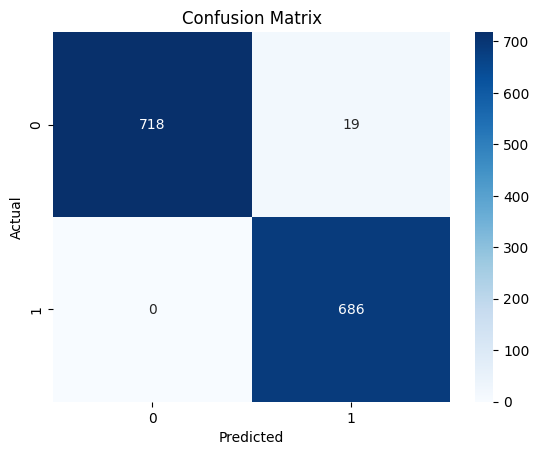

ROC AUC Score: 0.9995


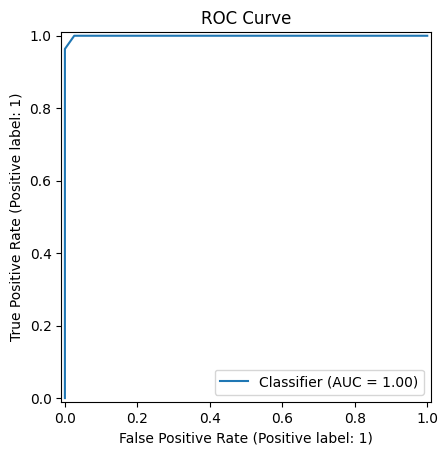

In [35]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.show()


- The evaluation metrics indicate that the Random Forest Classifier model is performing exceptionally well on this dataset. It has very high accuracy, precision, recall, and F1-scores for both classes, and an almost perfect AUC score. The confusion matrix shows that the model is particularly good at identifying good gRNAs (zero false negatives).

# Evolutionary Algorithm to Optimize gRNA Sequences

This algorithm uses an evolutionary strategy to design optimized CRISPR guide RNA (gRNA) sequences predicted to have high editing efficiency. Starting with a random population of 20-nucleotide sequences, it iteratively improves them over multiple generations.

Each gRNA candidate is one-hot encoded and evaluated by a trained Random Forest machine learning model that predicts its editing efficiency based on sequence features. The algorithm selects the top-performing sequences and applies genetic operators — crossover (mixing parts of two sequences) and mutation (randomly changing nucleotides) — to generate a new population.

Through this process of selection, recombination, and mutation, the population evolves toward sequences with higher predicted efficiency. After multiple generations, the algorithm outputs the top candidate gRNAs, providing a computational method to suggest effective CRISPR guides without costly laboratory screening.

## imports

In [58]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## Simulate gRNA Sequences and Activity Labels

In [60]:
# Simulated sequences (20-nt) and binary activity (1 = efficient, 0 = inefficient)
gRNAs = [''.join(random.choices(['A', 'T', 'C', 'G'], k=20)) for _ in range(1000)]
labels = np.random.randint(0, 2, size=1000)

# one hot encoding
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0],
               'T': [0, 1, 0, 0],
               'C': [0, 0, 1, 0],
               'G': [0, 0, 0, 1]}
    return np.array([mapping[base] for base in seq]).flatten()

X = np.array([one_hot_encode(seq) for seq in gRNAs])
y = np.array(labels)


## Training RF

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.47


## Evolutionary Algorithm

In [62]:
NUCLEOTIDES = ['A', 'T', 'C', 'G']

def random_gRNA(length=20):
    return ''.join(random.choices(NUCLEOTIDES, k=length))

def fitness(gRNA_seq):
    encoded = one_hot_encode(gRNA_seq)
    return rf.predict_proba(encoded.reshape(1, -1))[0][1]
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:]

def mutate(seq, mutation_rate=0.1):
    seq = list(seq)
    for i in range(len(seq)):
        if random.random() < mutation_rate:
            seq[i] = random.choice(NUCLEOTIDES)
    return ''.join(seq)

def evolve(pop_size=50, generations=20, mutation_rate=0.1):
    population = [random_gRNA() for _ in range(pop_size)]

    for gen in range(generations):
        scored = [(seq, fitness(seq)) for seq in population]
        scored.sort(key=lambda x: x[1], reverse=True)

        print(f"Generation {gen+1}: Best Score = {scored[0][1]:.4f}")

        top_half = [x[0] for x in scored[:pop_size // 2]]

        next_gen = []
        while len(next_gen) < pop_size:
            p1, p2 = random.sample(top_half, 2)
            child = crossover(p1, p2)
            child = mutate(child, mutation_rate)
            next_gen.append(child)

        population = next_gen

    final_scored = [(seq, fitness(seq)) for seq in population]
    final_scored.sort(key=lambda x: x[1], reverse=True)
    return final_scored[:10]  # top 10


## Runing the evolution

In [63]:
top_guides = evolve(pop_size=50, generations=20, mutation_rate=0.1)

print("\nTop Evolved gRNAs:")
for seq, score in top_guides:
    print(f"{seq} — Score: {score:.4f}")


Generation 1: Best Score = 0.6800
Generation 2: Best Score = 0.7300
Generation 3: Best Score = 0.7000
Generation 4: Best Score = 0.6700
Generation 5: Best Score = 0.7100
Generation 6: Best Score = 0.7100
Generation 7: Best Score = 0.7300
Generation 8: Best Score = 0.7600
Generation 9: Best Score = 0.7300
Generation 10: Best Score = 0.7400
Generation 11: Best Score = 0.7700
Generation 12: Best Score = 0.7700
Generation 13: Best Score = 0.7600
Generation 14: Best Score = 0.7800
Generation 15: Best Score = 0.7800
Generation 16: Best Score = 0.7600
Generation 17: Best Score = 0.7900
Generation 18: Best Score = 0.7800
Generation 19: Best Score = 0.7800
Generation 20: Best Score = 0.7900

Top Evolved gRNAs:
GAGTTAGGTGTACAGCACAC — Score: 0.7700
GTATAAGGTGTAACGCAAAA — Score: 0.7600
GACTTCTTTGTAAAGCACAG — Score: 0.7600
GTACCGTGTGTAAAGCCCAA — Score: 0.7500
GCCCCGTGATTAAAGCACAG — Score: 0.7500
GCCCACGAGGTACAGTATAT — Score: 0.7500
AACCTGGTCGTACAGCACAA — Score: 0.7500
GCCTCCGATGTTCAGGGAAA — Score: 